C:\Users\13532\AppData\Local\Temp\ipykernel_36372\1191050973.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(output_path)  # 确保在处理后的 grid 上调用 to_file


                                            geometry name  FID
0  POLYGON ((73.45570 38.44871, 73.45570 38.94871...   新疆    0
1  POLYGON ((73.45570 38.94871, 73.45570 39.44871...   新疆    1
2  POLYGON ((73.45570 39.44871, 73.45570 39.94871...   新疆    2
3  POLYGON ((73.45570 39.94871, 73.45570 40.44871...   新疆    3
4  POLYGON ((73.95570 38.44871, 73.95570 38.94871...   新疆    4
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  5210 non-null   geometry
 1   name      5210 non-null   object  
 2   FID       5210 non-null   int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 122.2+ KB


C:\Users\13532\AppData\Local\Temp\ipykernel_36372\1191050973.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_point = gpd.GeoDataFrame(grid[['FID']], geometry=grid.centroid, crs=grid.crs)


       FID                    geometry
0        0   POINT (73.70570 38.69871)
1        1   POINT (73.70570 39.19871)
2        2   POINT (73.70570 39.69871)
3        3   POINT (73.70570 40.19871)
4        4   POINT (74.20570 38.69871)
...    ...                         ...
5205  5205  POINT (125.70570 22.19871)
5206  5206  POINT (126.20570 22.19871)
5207  5207  POINT (126.20570 22.69871)
5208  5208  POINT (126.70570 22.69871)
5209  5209  POINT (126.70570 23.19871)

[5210 rows x 2 columns]


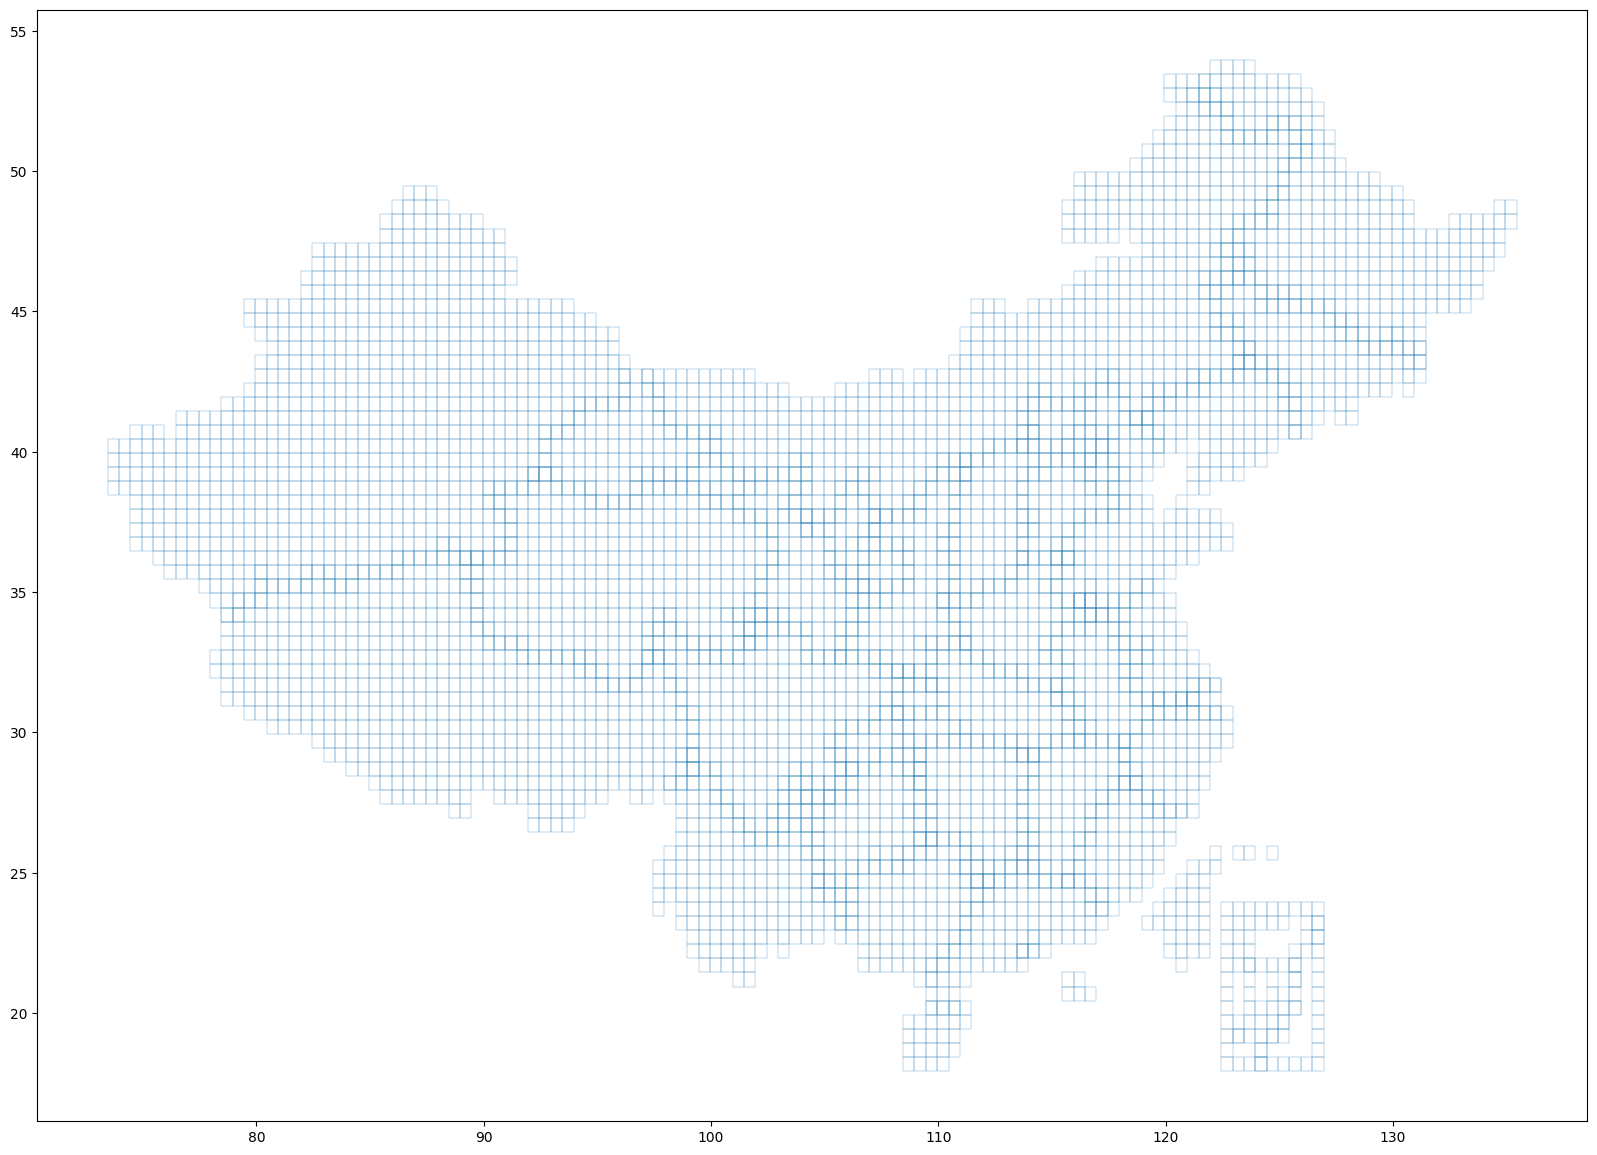

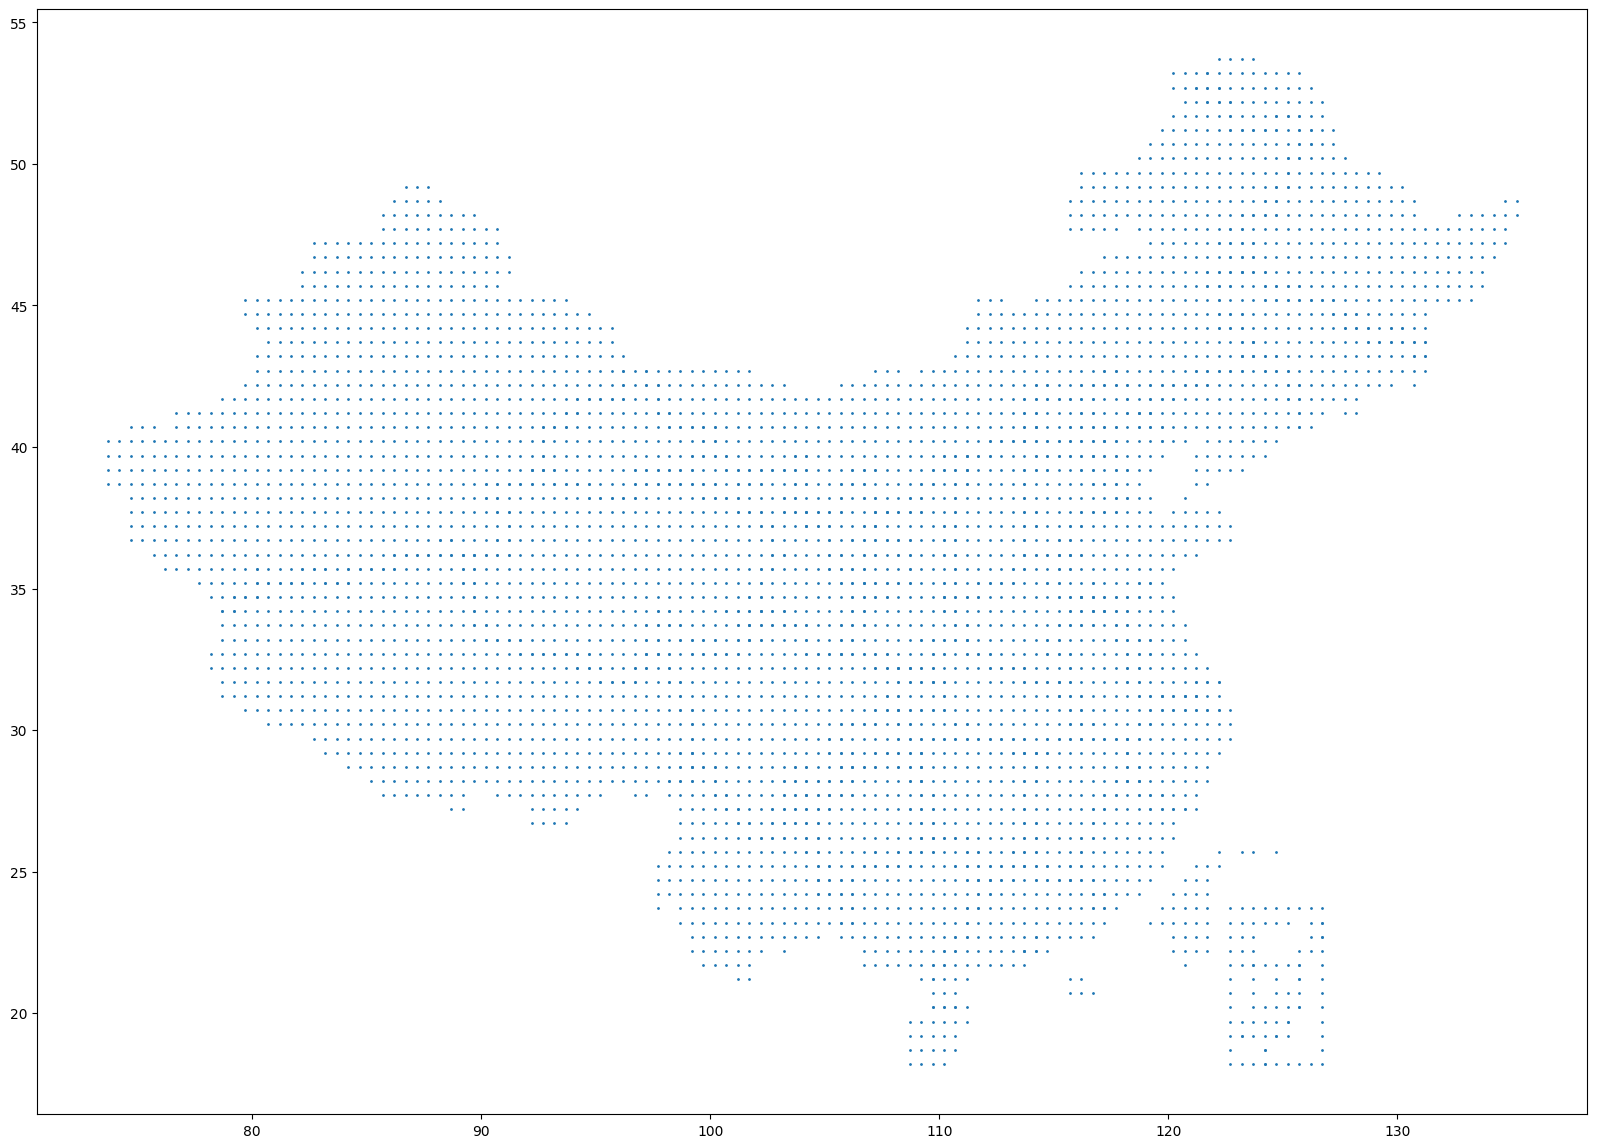

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm

import geopandas as gpd
from shapely.geometry import Point, Polygon
from osgeo import gdal, osr, ogr


# 从网络URL读取GeoJSON数据
path = 'C:/Users/13532/pycode/huawei/data/矢量/china.json'
gdf = gpd.read_file(path)

def make_grid(boundary, radius):
    # 以边界的中心点按照radius半径进行外扩
    minx, miny, maxx, maxy = boundary.total_bounds
    deltax = ((maxx-minx) % (radius*2)) / 2
    deltay = ((maxy-miny) % (radius*2)) / 2
    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay
    cells = []
    for x in np.arange(minx, maxx, radius*2):
        for y in np.arange(miny, maxy, radius*2):
            cells.append(Polygon([(x, y), (x, y+radius*2), (x+radius*2, y+radius*2), (x+radius*2, y), (x, y)]))
    return gpd.GeoDataFrame(cells, columns=['geometry'], crs=boundary.crs).sjoin(boundary, how='inner')

# 创建网格
grid = make_grid(gdf, 0.25)

# 确保所有几何对象是多边形类型
grid['geometry'] = grid['geometry'].apply(lambda poly: Polygon(poly.exterior.coords))

# 绘制边界
grid.boundary.plot(lw=0.2, figsize=(20, 20))

# 保存为 Shapefile
output_path = 'data/矢量/grid.shp'
grid.to_file(output_path)  # 确保在处理后的 grid 上调用 to_file

# 重置索引并添加 'FID' 列
grid.reset_index(inplace=True)
grid = grid[['geometry', 'name']].copy()
grid['FID'] = grid.index

# 打印前几行来检查 'FID' 列
print(grid.head())

# 使用 .info() 方法查看所有列的详细信息
grid.info()

# 创建 grid_point
grid_point = gpd.GeoDataFrame(grid[['FID']], geometry=grid.centroid, crs=grid.crs)
grid_point.plot(markersize=1, figsize=(20,20))
print(grid_point)

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# 加载灾害数据
disaster_data = pd.read_csv('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster_severity_1990_2020.csv')

# 确保数据类型正确
disaster_data['year'] = disaster_data['year'].astype(int)

# 创建一个包含年份的循环
for year in range(1990, 2021):
    # 过滤出当前年份的灾害数据
    year_data = disaster_data[disaster_data['year'] == year]

    # 将灾害严重度与网格点进行匹配
    grid_with_severity = grid_point.copy()
    severity_data = year_data.groupby('FID')['severity'].max().reset_index()
    grid_with_severity = grid_with_severity.merge(severity_data, on='FID', how='left').fillna(0)

    # 设置点的大小和颜色
    grid_with_severity['size'] = 10  # 设置固定的点大小
    max_severity = grid_with_severity['severity'].max()
    grid_with_severity['color'] = grid_with_severity['severity'] / max_severity  # 归一化颜色

    # 绘制图形
    fig, ax = plt.subplots(figsize=(10, 10))
    base = grid.boundary.plot(ax=ax, linewidth=0.5, color='black')  # 绘制网格边界
    scatter = ax.scatter(grid_with_severity.geometry.x, grid_with_severity.geometry.y,
                         s=grid_with_severity['size'], c=grid_with_severity['color'],
                         cmap='Reds', alpha=0.6)

    # 添加渐变条
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Severity', rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['0', str(max_severity // 2), str(max_severity)])  # 显示标签

    # 设置标题和其他细节
    ax.set_title(f'Disaster Severity for {year}', fontsize=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.axis('equal')

    # 保存为PNG格式
    plt.savefig(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster/disaster_severity_{year}.png', format='png')
    plt.close()  # 关闭当前图形以释放内存


In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# 加载灾害数据
disaster_data = pd.read_csv('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster_severity_1990_2020.csv')

# 确保数据类型正确
disaster_data['year'] = disaster_data['year'].astype(int)

# 创建每张大图的图形
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # 将2D数组展开为1D，以便于索引

# 创建一个包含年份的循环
for i, year in enumerate(range(1990, 2021)):
    if i >= 6:  # 检查是否超过6个子图
        break

    # 过滤出当前年份的灾害数据
    year_data = disaster_data[disaster_data['year'] == year]

    # 将灾害严重度与网格点进行匹配
    grid_with_severity = grid_point.copy()
    severity_data = year_data.groupby('FID')['severity'].max().reset_index()
    grid_with_severity = grid_with_severity.merge(severity_data, on='FID', how='left').fillna(0)

    # 设置点的大小和颜色
    grid_with_severity['size'] = 10  # 设置固定的点大小
    max_severity = grid_with_severity['severity'].max()
    grid_with_severity['color'] = grid_with_severity['severity'] / max_severity  # 归一化颜色

    # 绘制每个年份的图形
    scatter = axes[i].scatter(grid_with_severity.geometry.x, grid_with_severity.geometry.y,
                              s=grid_with_severity['size'], c=grid_with_severity['color'],
                              cmap='Reds', alpha=0.6)

    # 设置标题和其他细节
    axes[i].set_title(f'Disaster Severity for {year}', fontsize=10)
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    axes[i].axis('equal')

# 添加渐变条
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Severity', rotation=270, labelpad=20)

# 调整布局，设置子图之间的间距
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.2)

# 保存整合后的图像
plt.savefig('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster/severity_combined.png', format='png', bbox_inches='tight')
plt.close()  # 关闭当前图形以释放内存


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Haversine函数，用于计算两点之间的距离
def haversine(coord1, coord2):
    R = 6371.0  # 地球半径，单位为公里
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # 返回距离，单位为公里

# 读取空间数据
gdf = gpd.read_file('C:/Users/13532/pycode/huawei/data/矢量/grid.shp')  # 替换为你的数据文件路径

# 计算几何中心点
centroids = gdf.geometry.centroid
coords = centroids.apply(lambda point: (point.y, point.x)).tolist()  # 提取经纬度

# 计算距离矩阵
dist_matrix = squareform(pdist(coords, metric=haversine))

# 使用距离的倒数作为权重矩阵，避免除以零
weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))

# 构建邻接图
G = nx.from_numpy_array(weight_matrix)

# 绘制邻接图
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G, pos,
    ax=ax,
    node_size=50,
    node_color="blue",
    edge_color="red",
    with_labels=False
)
plt.title('Spatial Neighbor Graph')
plt.show()

# 分析人口、GDP、降雨量数据
# 假设你有不同年份的人口和GDP数据，放在不同的DataFrame中
population_data = pd.read_csv('D:\研究生学习资料\比赛\华为杯\D数据集\data\pop\pop1990.csv')  # 替换为实际路径
gdp_data = pd.read_csv('D:\研究生学习资料\比赛\华为杯\D数据集\data\gdp\gdp1990.csv')  # 替换为实际路径
disaster_severity = pd.read_csv('D:\研究生学习资料\比赛\华为杯\D数据集\data\disaster_severity_1990_2020.csv')  # 替换为实际路径

disaster_severity_1990 = disaster_severity[disaster_severity['year']==1990]
# 合并数据
# 假设FID是连接不同数据的关键字
merged_data = gdf.merge(population_data, on='FID').merge(gdp_data, on='FID').merge(disaster_severity_1990, on='FID')

# 进行空间分析，例如计算不同区域的人口密度和GDP
merged_data['population_density'] = merged_data['pop1990']  
merged_data['gdp_per_capita'] = merged_data['gdp1990']

# 可视化人口密度和GDP
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 绘制人口密度
merged_data.plot(column='population_density', ax=axes[0], legend=True, cmap='Blues')
axes[0].set_title('Population Density')

# 绘制人均GDP
merged_data.plot(column='gdp_per_capita', ax=axes[1], legend=True, cmap='Greens')
axes[1].set_title('GDP per Capita')

plt.show()


C:\Users\13532\AppData\Local\Temp\ipykernel_10212\4158111945.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid
C:\Users\13532\AppData\Local\Temp\ipykernel_10212\4158111945.py:33: RuntimeWarning: divide by zero encountered in divide
  weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000021D137D7CA0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000021D5415F0D0> (for post_execute):


KeyboardInterrupt: 

C:\Users\13532\AppData\Local\Temp\ipykernel_10212\3089907351.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid
C:\Users\13532\AppData\Local\Temp\ipykernel_10212\3089907351.py:37: RuntimeWarning: divide by zero encountered in divide
  weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))


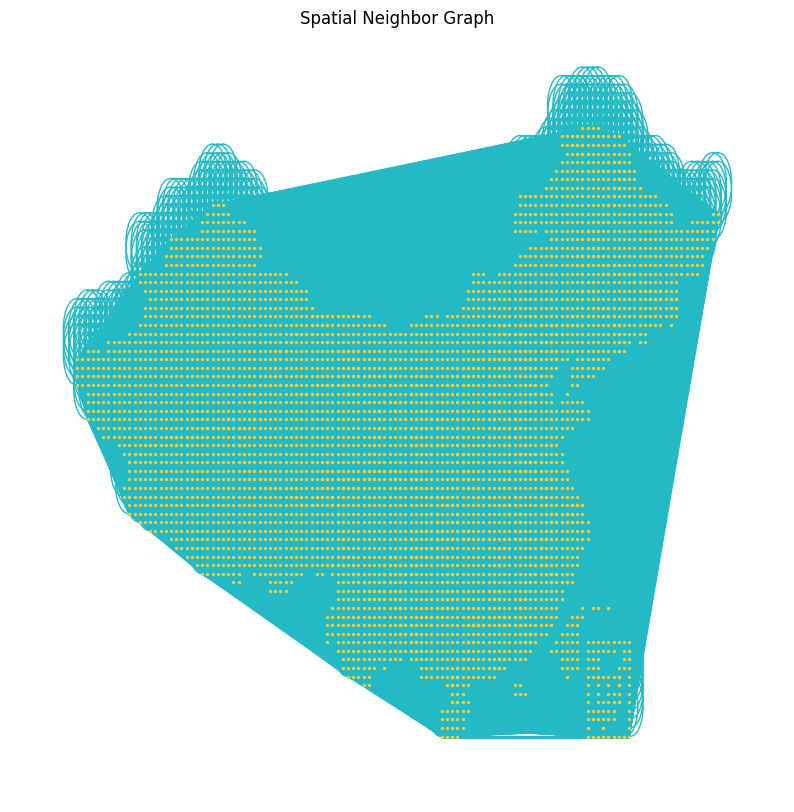

ValueError: '#FFF0BC' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

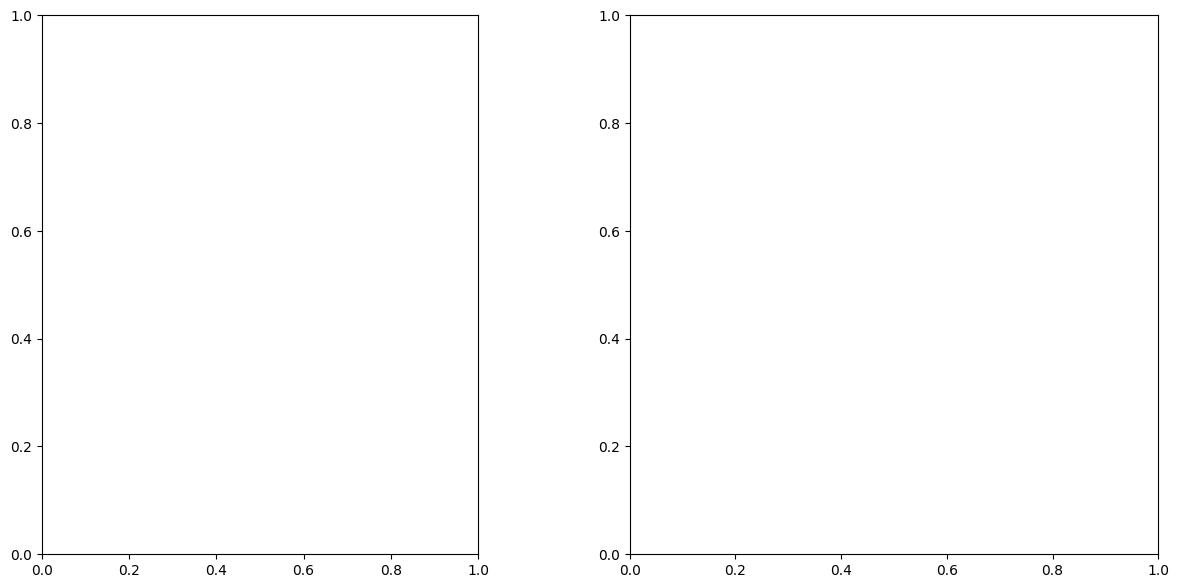

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Haversine函数，用于计算两点之间的距离
#def haversine(coord1, coord2):
#    R = 6371.0  # 地球半径，单位为公里
#    lat1, lon1 = np.radians(coord1)
#    lat2, lon2 = np.radians(coord2)
#
#    dlat = lat2 - lat1
#    dlon = lon2 - lon1
#    
#    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
#    c = 2 * np.arcsin(np.sqrt(a))
#    
#    return R * c  # 返回距离，单位为公里

# 读取空间数据
gdf = gpd.read_file('C:/Users/13532/pycode/huawei/data/矢量/grid.shp')  # 替换为你的数据文件路径

# 重置索引并添加 'FID' 列
gdf.reset_index(drop=True, inplace=True)
gdf['FID'] = gdf.index  # 将索引作为 FID 列

## 计算几何中心点
#centroids = gdf.geometry.centroid
#coords = centroids.apply(lambda point: (point.y, point.x)).tolist()  # 提取经纬度

## 计算距离矩阵
#dist_matrix = squareform(pdist(coords, metric=haversine))
#
# 使用距离的倒数作为权重矩阵，避免除以零
#weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))

# 构建邻接图
#G = nx.from_numpy_array(weight_matrix)

# 绘制邻接图
#pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}
#fig, ax = plt.subplots(figsize=(10, 10))
#nx.draw(
#    G, pos,
#    ax=ax,
#    node_size=2,
#    node_color="#EECA40",
#    edge_color="#23BAC5",
#    with_labels=False
#)
#plt.title('Spatial Neighbor Graph')
#plt.show()
#
# 分析人口、GDP、降雨量数据
population_data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/pop/pop{}.csv')  # 替换为实际路径
gdp_data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/gdp/gdp{}.csv')  # 替换为实际路径
disaster_severity = pd.read_csv('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster_severity_1990_2020.csv')  # 替换为实际路径

# 筛选1990年的灾害严重性数据
disaster_severity_1990 = disaster_severity[disaster_severity['year'] == 1997]

# 合并数据
merged_data = gdf.merge(population_data, on='FID', how='left') \
                  .merge(gdp_data, on='FID', how='left') \
                  .merge(disaster_severity_1990, on='FID', how='left')

# 进行空间分析，例如计算不同区域的人口密度和GDP
merged_data['population_density'] = merged_data['pop1997']  # 假设有一个人口列
merged_data['gdp_per_capita'] = merged_data['gdp1997']  # 假设有一个GDP列

# 可视化人口密度和GDP
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 绘制人口密度
merged_data.plot(column='population_density', ax=axes[0], legend=True, cmap='OrRd', edgecolor='white', 
                 vmin=merged_data['population_density'].quantile(0.1), 
                 vmax=merged_data['population_density'].quantile(0.9))  # 使用渐变色并集中颜色范围
axes[0].set_title('Population Density')

# 绘制人均GDP
merged_data.plot(column='gdp_per_capita', ax=axes[1], legend=True, cmap='Blues', edgecolor='white', 
                 vmin=merged_data['gdp_per_capita'].quantile(0.1), 
                 vmax=merged_data['gdp_per_capita'].quantile(0.9))  # 使用渐变色并集中颜色范围
axes[1].set_title('GDP per Capita')

plt.tight_layout()  # 调整布局以避免重叠
plt.show()



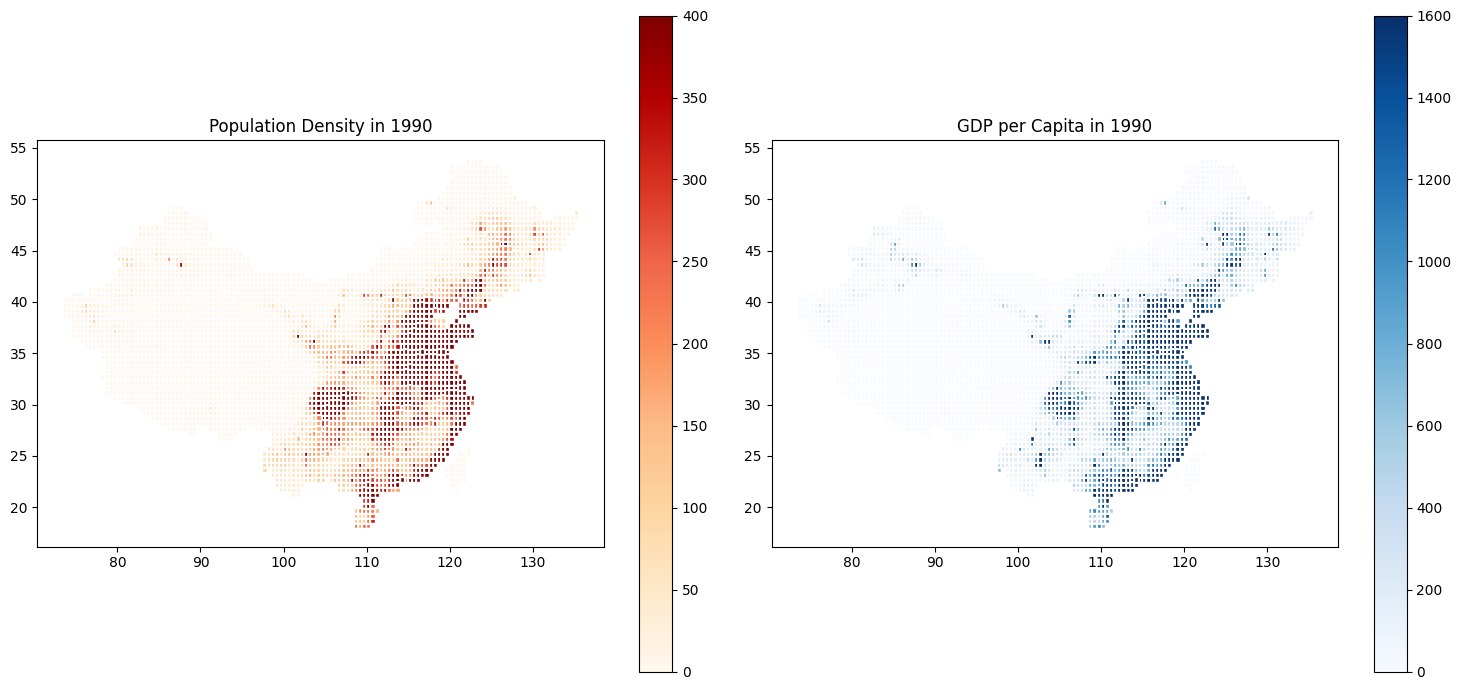

In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 读取空间数据
gdf = gpd.read_file('C:/Users/13532/pycode/huawei/data/矢量/grid.shp')  # 替换为你的数据文件路径
# 重置索引并添加 'FID' 列
gdf.reset_index(drop=True, inplace=True)
gdf['FID'] = gdf.index 

# 定义你想分析的年份列表
years_to_analyze = [1990]  # 自定义你想分析的年份

# 初始化合并数据的列表
merged_data_list = []

# 循环读取每个年份的数据并合并
for year in years_to_analyze:
    # 读取数据
    population_data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/pop/pop{year}.csv')  # 替换为实际路径
    gdp_data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/gdp/gdp{year}.csv')  # 替换为实际路径
    disaster_severity = pd.read_csv('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster_severity_1990_2020.csv')  # 替换为实际路径

    # 筛选当前年份的灾害严重性数据
    disaster_severity_year = disaster_severity[disaster_severity['year'] == year]

    # 合并数据
    merged_data = gdf.merge(population_data, on='FID', how='left') \
                      .merge(gdp_data, on='FID', how='left') \
                      .merge(disaster_severity_year, on='FID', how='left')

    # 进行空间分析，例如计算不同区域的人口密度和GDP
    merged_data['population_density'] = merged_data[f'pop{year}']  # 假设有一个人口列
    merged_data['gdp_per_capita'] = merged_data[f'gdp{year}']  # 假设有一个GDP列

    # 添加合并的数据到列表
    merged_data_list.append((year, merged_data))

# 可视化每个年份的人口密度和GDP
for year, data in merged_data_list:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # 绘制人口密度
    data.plot(column='population_density', ax=axes[0], legend=True, cmap='OrRd', edgecolor='white', 
              vmin=0, vmax=400)  # 统一设置最大值为400
    axes[0].set_title(f'Population Density in {year}')

    # 绘制人均GDP
    data.plot(column='gdp_per_capita', ax=axes[1], legend=True, cmap='Blues', edgecolor='white', 
              vmin=0, vmax=1600)  # 统一设置最大值为1600
    axes[1].set_title(f'GDP per Capita in {year}')

    plt.tight_layout()  # 调整布局以避免重叠
    # 保存为PNG格式
    plt.savefig(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/pop_gdp_pic/population_gdp_{year}.png', format='png', dpi=300)  # 设置文件名和分辨率
    plt.show()
    


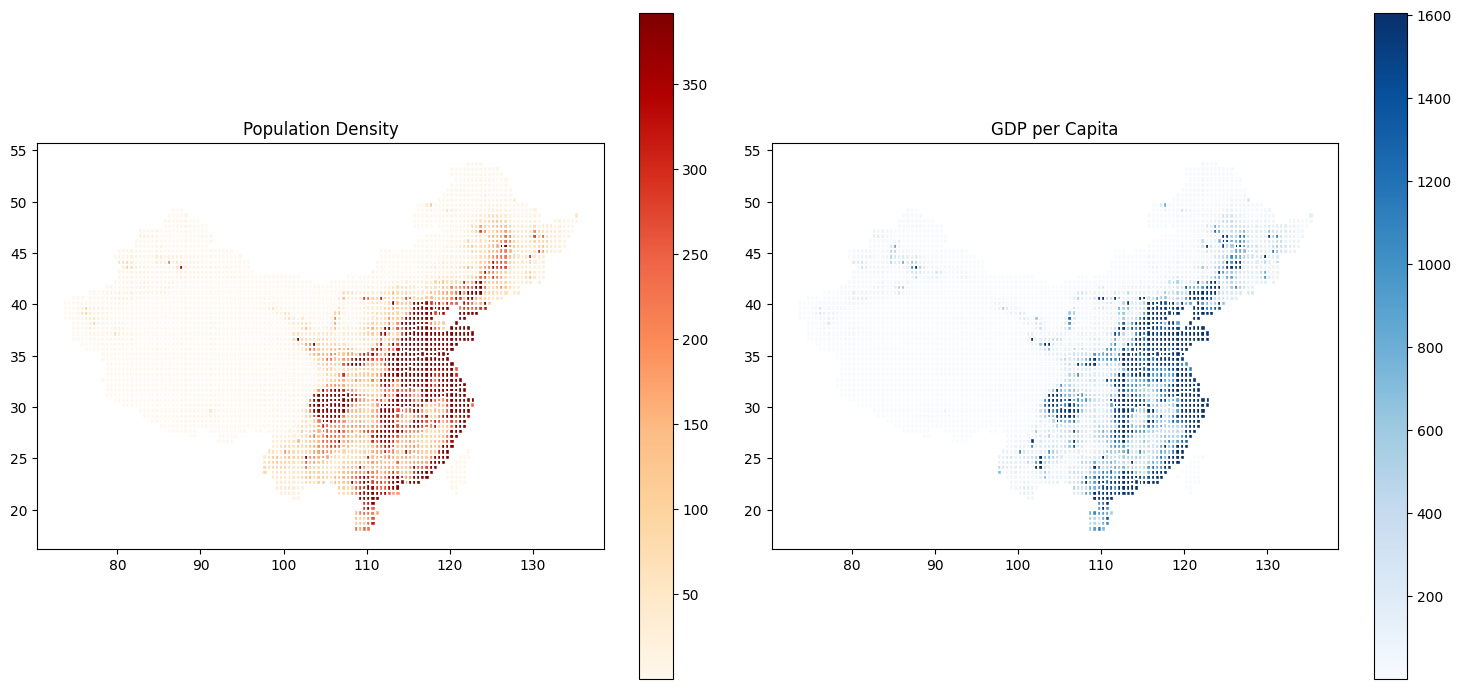

In [7]:
# 进行空间分析，例如计算不同区域的人口密度和GDP
merged_data['population_density'] = merged_data['pop1990']  # 假设有一个人口列
merged_data['gdp_per_capita'] = merged_data['gdp1990']  # 假设有一个GDP列

# 可视化人口密度和GDP
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 绘制人口密度
merged_data.plot(column='population_density', ax=axes[0], legend=True, cmap='OrRd', edgecolor='white', 
                 vmin=merged_data['population_density'].quantile(0.1), 
                 vmax=merged_data['population_density'].quantile(0.9))  # 使用渐变色并集中颜色范围
axes[0].set_title('Population Density')

# 绘制人均GDP
merged_data.plot(column='gdp_per_capita', ax=axes[1], legend=True, cmap='Blues', edgecolor='white', 
                 vmin=merged_data['gdp_per_capita'].quantile(0.1), 
                 vmax=merged_data['gdp_per_capita'].quantile(0.9))  # 使用渐变色并集中颜色范围
axes[1].set_title('GDP per Capita')

plt.tight_layout()  # 调整布局以避免重叠
plt.show()


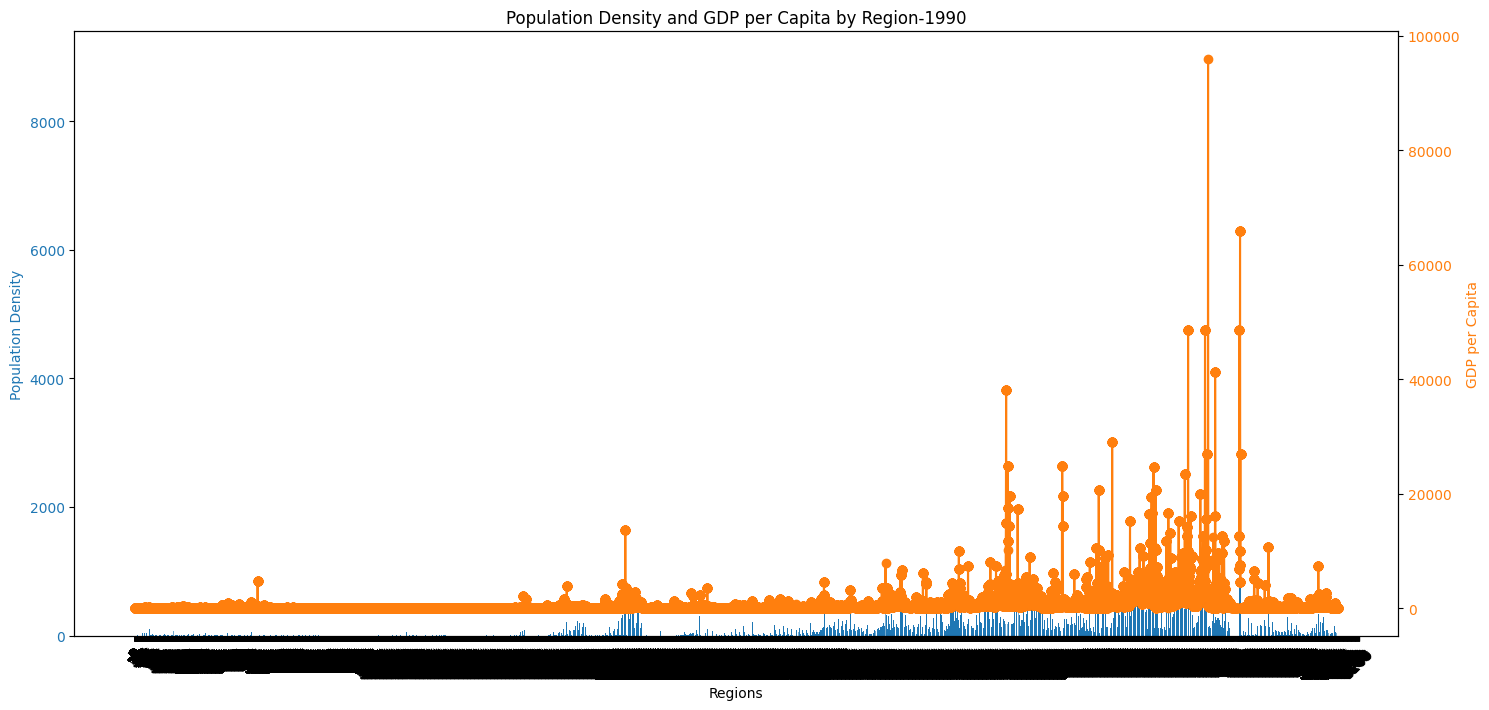

In [9]:
# 进行空间分析，例如计算不同区域的人口密度和GDP
merged_data['population_density'] = merged_data['pop1990']  # 假设有一个人口列
merged_data['gdp_per_capita'] = merged_data['gdp1990']  # 假设有一个GDP列

# 创建复合图
fig, ax1 = plt.subplots(figsize=(15, 7))

# 绘制人口密度
color1 = 'tab:blue'
ax1.set_xlabel('Regions')
ax1.set_ylabel('Population Density', color=color1)
ax1.bar(merged_data['FID'], merged_data['population_density'], color=color1, alpha=0.6, label='Population Density')
ax1.tick_params(axis='y', labelcolor=color1)

# 创建第二个y轴
ax2 = ax1.twinx()  
color2 = 'tab:orange'
ax2.set_ylabel('GDP per Capita', color=color2)
ax2.plot(merged_data['FID'], merged_data['gdp_per_capita'], color=color2, marker='o', label='GDP per Capita')
ax2.tick_params(axis='y', labelcolor=color2)

# 设置x轴的标签
ax1.set_xticks(merged_data['FID'])
ax1.set_xticklabels(merged_data['FID'], rotation=45)

# 添加图例
fig.tight_layout()  # 调整布局以避免重叠
plt.title('Population Density and GDP per Capita by Region-1990')
plt.show()
